In [47]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

imagefile = 'train-images.idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)
labelfile = 'train-labels.idx1-ubyte'
labelarray = idx2numpy.convert_from_file(labelfile)

In [48]:
#Preprocessing Data
filtered1_images=[]
filtered1_labels=[]
filtered0_images=[]
filtered0_labels=[]
for i in range(0,len(labelarray)):
    if(labelarray[i]==0):
        filtered0_images.append(imagearray[i])
        filtered0_labels.append(labelarray[i])
    elif(labelarray[i]==1):
        filtered1_images.append(imagearray[i])
        filtered1_labels.append(labelarray[i])
filtered1_images = np.array(filtered1_images)
filtered1_labels = np.array(filtered1_labels)
filtered0_images = np.array(filtered0_images)
filtered0_labels = np.array(filtered0_labels)
data_set_images_index=[]
data_set_images_index.append(np.random.choice(len(filtered0_images),1000,False))
data_set_images_index.append(np.random.choice(len(filtered1_images),1000,False))
data_set_images=np.concatenate([
    filtered0_images[data_set_images_index[0]],
    filtered1_images[data_set_images_index[1]],
])
train_set_images=np.concatenate([
    data_set_images[0:1000],
    data_set_images[1000:2000],
])
train_set_labels=np.array([0]*1000 +[1]*1000)
test_set_images=np.concatenate([
    filtered0_images,
    filtered1_images
])
test_set_labels=np.array([0]*len(filtered0_images) +[1]*len(filtered1_images))
train_set_images = train_set_images.reshape(2000, -1)
test_set_images = test_set_images.reshape(len(filtered0_images)+len(filtered1_images), -1)
train_set_images=train_set_images.T
test_set_images=test_set_images.T
X_train_set_images=train_set_images
X_test_set_images=test_set_images
    
print(train_set_images.shape)
print(test_set_images.shape)


(784, 2000)
(784, 12665)


In [49]:
#Functions for Calculating MLE estimates
def mean(train_set_images_i):
    return np.mean(train_set_images_i, axis=1)  
def covariance(train_set_images_i, mean_i):
    diff = train_set_images_i - mean_i[:, None]
    covariance = 1/1000 * (diff @ diff.T)
    return covariance + np.eye(covariance.shape[0])*1e-6
def likelihood(x, mean_i, cov_inv, cov_det):
    if(cov_det==0):
        cov_det=5e-324#Smallest possible postive value in python
    diff = (x - mean_i).reshape(-1, 1) 
    return -0.5 * np.log(cov_det) - 0.5 * (diff.T @ cov_inv @ diff).item()
mean_0 = mean(train_set_images[:, :1000])
cov_0 = covariance(train_set_images[:, :1000], mean_0)
mean_1 = mean(train_set_images[:, 1000:2*1000])
cov_1 = covariance(train_set_images[:, 1000:2*1000], mean_1)
cov_inv0, cov_det0 = np.linalg.inv(cov_0), np.linalg.det(cov_0)
cov_inv1, cov_det1 = np.linalg.inv(cov_1), np.linalg.det(cov_1)


In [50]:
#PCA with using top five components
data_mean=np.mean(train_set_images, axis=1).reshape(-1,1)
centred_train_set_images=train_set_images-data_mean
centred_covariance=(centred_train_set_images)@(centred_train_set_images).T*(1/1999)
eValue,eVectors=np.linalg.eig(centred_covariance)
sorted_indices=np.argsort(eValue)[::-1]
eValue=eValue[sorted_indices]
eVectors=eVectors[:,sorted_indices]
count=5
U_p=eVectors[:,:5]
Y=U_p.T@centred_train_set_images
centred_test_images=test_set_images-data_mean
Y_test=U_p.T@centred_test_images
meancentred_0 = mean(Y[:, :1000])
covcentred_0 = covariance(Y[:, :1000], meancentred_0)

meancentred_1 = mean(Y[:, 1000:2*1000])
covcentred_1 = covariance(Y[:, 1000:2*1000], meancentred_1)

covcentred_inv0, covcentred_det0 = np.linalg.inv(covcentred_0), np.linalg.det(covcentred_0)
covcentred_inv1, covcentred_det1 = np.linalg.inv(covcentred_1), np.linalg.det(covcentred_1)
print(Y.shape)
print(Y_test.shape)

(5, 2000)
(5, 12665)


In [51]:
cuts=[]
for i in range(5):
    maxi=np.max(Y[i])
    mini=np.min(Y[i])
    var=(maxi-mini)/5
    cuts.append([var+mini,2*var+mini,3*var+mini])
weights=[]
for i in range(1800):
    weights.append(1/1800)
def lossOfCut(cutpoint,dimension):
    y_left=[]
    y_right=[]
    left1_count=0
    left0_count=0
    right1_count=0
    right0_count=0
    for i in range(1800):
        if(Y[dimension][i]<=cutpoint):
            y_left.append(i)
            if(train_set_labels[i]==1):
                left1_count+=1
            else:
                left0_count+=1
        else:
            y_right.append(i)
            if(train_set_labels[i]==1):
                right1_count+=1
            else:
                right0_count+=1
    left_pred=-1
    right_pred=-1
    if(left0_count>left1_count):
        left_pred=0
        right_pred=1
    elif(left0_count<left1_count):
        left_pred=1
        right_pred=0
    elif(right0_count>right1_count):
        left_pred=0
        right_pred=1
    else:
        left_pred=1
        right_pred=0
    loss=0
    missclassified=[]
    for i in y_left:
        if(train_set_labels[i]!=left_pred):
            loss+=weights[i]
            missclassified.append(i)
    for i in y_right:
        if(train_set_labels[i]!=right_pred):
            loss+=weights[i]
            missclassified.append(i)
    loss/=(sum(weights))
    return (loss,left_pred,right_pred,missclassified)

In [52]:
models=[]
model_weights=[]
iter=0
train_errors=[]
test_errors=[]
train_losses=[]
test_losses=[]
val_losses=[]
# Select validation indices: first 100 from class 0 and next 100 from class 1
val_indices=np.concatenate([np.arange(100), np.arange(1000, 1100)])
# Extract validation set
Y_val=Y[:,val_indices]
val_set_labels=train_set_labels[val_indices]
# Update training set to exclude validation indices
train_indices=np.setdiff1d(np.arange(len(train_set_labels)),val_indices)
Y = Y[:,train_indices]
train_set_labels=train_set_labels[train_indices]

early_stop_threshold = 1e-4
patience=50
no_improve_count=0
def calculate_error(X,y,models,model_weights):
    preds=np.zeros(len(y))
    for (cut,dim,left,right),alpha in zip(models,model_weights):
        pred=np.where(X[dim]<=cut,left,right)
        pred=2*pred-1
        preds+=alpha*pred
    final_pred=(preds>0).astype(int)
    return np.mean(final_pred!=y)
def exponential_loss(X, y, models, model_weights):
    f_x=np.zeros(len(y))
    for (cut, dim, left, right), alpha in zip(models, model_weights):
        h_t=np.where(X[dim]<=cut,left,right)
        h_t=2*h_t-1 
        f_x+=alpha*h_t
    return np.mean(np.exp(-y*f_x))
train_labels_signed=2*train_set_labels-1
test_labels_signed=2*test_set_labels-1
prev_error = None
while(iter<=200):
    left_pred=-1
    right_pred=-1
    best_cut=-1
    min_loss=float('inf')
    is_missclassified=[]
    best_dim=-1
    for i in range(5):
        for j in range(3):
            lossVal,leftVal,rightVal,missclass=lossOfCut(cuts[i][j],i)
            if(lossVal<min_loss):
                min_loss=lossVal
                left_pred=leftVal
                right_pred=rightVal
                is_missclassified=missclass
                best_cut=cuts[i][j]
                best_dim=i
    alpha=0.5*np.log((1-min_loss)/min_loss)
    for i in is_missclassified:
        pred = left_pred if Y[best_dim][i]<=best_cut else right_pred
        pred=2*pred-1
        true=2*train_set_labels[i]-1
        weights[i]*=np.exp(2*alpha)
    models.append([best_cut,best_dim,left_pred,right_pred])
    model_weights.append(alpha)
    iter+=1
    curr_error=calculate_error(Y, train_set_labels, models, model_weights)
    train_errors.append(curr_error)
    # if prev_error is not None and abs(curr_error-prev_error)<early_stop_threshold:
    #     no_improve_count+=1
    #     if no_improve_count>=patience:
    #         print(f"Early stopping at iteration {iter} due to minimal change in training error.")
    #         break
    # else:
    #     no_improve_count=0
    prev_error=curr_error

    if(iter%10==0):
        print(iter," ",train_errors[-1])
    test_errors.append(calculate_error(Y_test,test_set_labels,models,model_weights))
    train_losses.append(exponential_loss(Y, train_labels_signed,models, model_weights))
    test_losses.append(exponential_loss(Y_test, test_labels_signed,models,model_weights))
    val_losses.append(exponential_loss(Y_val, 2*val_set_labels-1,models,model_weights))



10   0.028888888888888888
20   0.027777777777777776
30   0.02388888888888889
40   0.02388888888888889
50   0.02388888888888889
60   0.02388888888888889
70   0.02388888888888889
80   0.02388888888888889
90   0.02388888888888889
100   0.02388888888888889
110   0.02388888888888889
120   0.02388888888888889
130   0.02388888888888889
140   0.02388888888888889
150   0.02388888888888889
160   0.02388888888888889
170   0.02388888888888889
180   0.02388888888888889
190   0.02388888888888889
200   0.02388888888888889


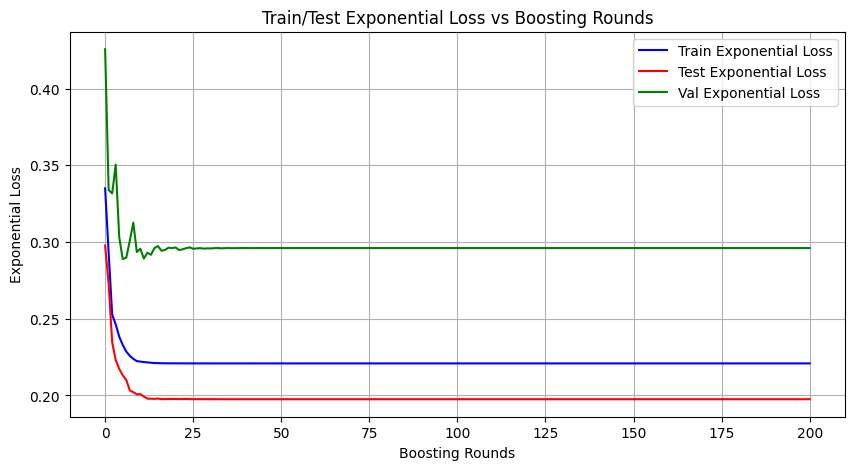

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Train Exponential Loss', color='blue')
plt.plot(range(len(test_losses)), test_losses, label='Test Exponential Loss', color='red')
plt.plot(range(len(val_losses)), val_losses, label='Val Exponential Loss', color='green')
plt.xlabel("Boosting Rounds")
plt.ylabel("Exponential Loss")
plt.title("Train/Test Exponential Loss vs Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()


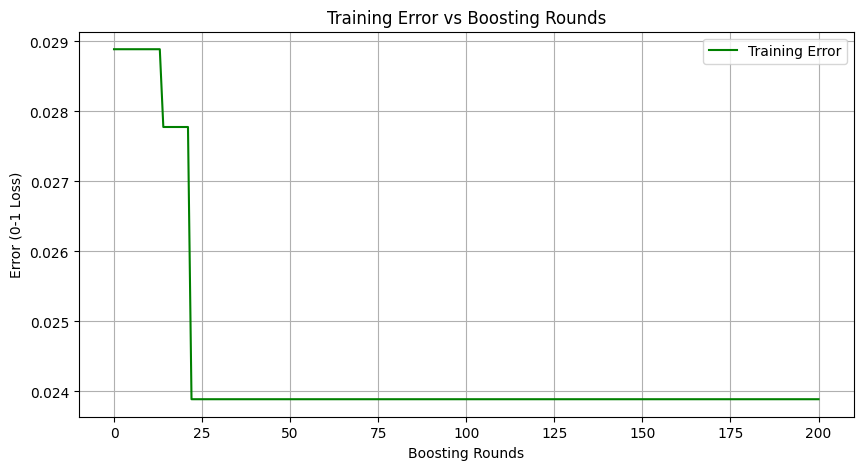

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_errors)), train_errors, label='Training Error', color='green')
plt.xlabel('Boosting Rounds')
plt.ylabel('Error (0-1 Loss)')
plt.title('Training Error vs Boosting Rounds')
plt.grid(True)
plt.legend()
plt.show()
